# Processing Vegetation Index Data (VIIRS, Global)

James Yoon 

---

**Last updated:** 4 July 2023

This script reads in vegetation index data (from EarthData) and regrids the data to a desired resolution. This method is different from the tiles in that it is taking in a different (global) dataset and regrids using linear interpolation onto a regular grid.

The EarthData link to the VIIRS dataset is [here](https://search.earthdata.nasa.gov/downloads/4326454186?q=VNP13C1.A). This dataset (titled "VIIRS" under Vegetation_Indices on Hermes) corresponds to **VIIRS/NPP Vegetation Indices 16-Day L3 Global 0.05Deg CMG V001** on EarthData.

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
import pandas as pd
from datetime import datetime, timedelta
import netCDF4 as nc

from satellite_processing_functions import global_MODIS_grid, convert_to_string

# Part I: Setting Up The Parameters

Feel free to add geographic_descriptors and their corresponding latitude-longitude bounding boxes.

In [50]:
prefix = '/home/disk/p/jyyoon/'

geographic_descriptor = 'PNW'

if geographic_descriptor == 'Ozark':
    lon_min, lat_min, lon_max, lat_max = np.array([-96,34,-89,39])
elif geographic_descriptor == 'California':
    lon_min, lat_min, lon_max, lat_max = np.array([38,-121.1,39.5,-120.1])
elif geographic_descriptor == 'PNW':
    lon_min, lat_min, lon_max, lat_max = np.array([-130,41,-116,52])
elif geographic_descriptor == 'Sudd':
    lon_min, lat_min, lon_max, lat_max = np.array([21.423340,2.964984,37.089844,11.609193])
elif geographic_descriptor == 'None':
    lon_min, lat_min, lon_max, lat_max = np.array([-180,-90,180,90])

In [51]:
year_start = 2016
doys_start = 73

year_end = 2016
doys_end = 81

starting_date = pd.to_datetime(f'{year_start}-{doys_start}', format='%Y-%j')
ending_date = pd.to_datetime(f'{year_end}-{doys_end}', format='%Y-%j')
time_array = pd.to_datetime(np.arange(starting_date, ending_date, timedelta(days = 1)))

## Reprojection

Unfortunately, the data is in MODIS coordinates (and not our typical lat/lon coordinates)! We need to do the following transformation to get our data into lat/lon.

Coordinate codes are from: https://gis.stackexchange.com/questions/326444/how-to-create-a-grid-of-pixel-coordinates-from-the-corners-of-a-modis-tile

In [52]:
# Create lat, lon coordinates 

nx, ny = (7200, 3600)
step = 0.025
modis_lon, modis_lat = global_MODIS_grid(nx, ny, step);

# Only interpolate if you need to! You will be linearly interpolating, which is less ideal
do_interpolation = False;

new_step_lon = 0.1
new_step_lat = 0.1

new_lat = np.arange(-90, 90, new_step_lat)
new_lon = np.arange(-180, 180, new_step_lon)

In [63]:
ds = pd.DataFrame()

for time in time_array:

    # Read in time data
    year = time.year
    doy = str(time.dayofyear).zfill(3)
    
    files = glob(f"{prefix}hermes/jyyoon/Vegetation_Indices/VIIRS/VNP13C1.A{year}{doy}.*h5")

    # If there are files with the corresponding name,
    if len(files) > 0:
        
        for fn in files:
            metadata = xr.open_dataset(fn) # This is just for metadata
            start_date = metadata.StartTime
            end_date = metadata.EndTime
            mean_date = pd.to_datetime(start_date) + timedelta(days = 8)

            df_data = xr.open_dataset(fn, group = 'HDFEOS/GRIDS/NPP_Grid_16Day_VI_CMG/Data Fields', mask_and_scale = True) # This contains the bulk of the product
            df_day = df_data[['CMG 0.05 Deg 16 days EVI2', 'CMG 0.05 Deg 16 days NDVI', 'CMG 0.05 Deg 16 days NIR reflectance',
                         'CMG 0.05 Deg 16 days VI Quality', 'CMG 0.05 Deg 16 days pixel reliability', 
                         'CMG 0.05 Deg 16 days SWIR1 reflectance', 'CMG 0.05 Deg 16 days SWIR2 reflectance',
                         'CMG 0.05 Deg 16 days SWIR3 reflectance', 'CMG 0.05 Deg 16 days blue reflectance',
                         'CMG 0.05 Deg 16 days green reflectance', 'CMG 0.05 Deg 16 days red reflectance']].to_dataframe()
            
            df_day = pd.DataFrame(np.column_stack([modis_lat, modis_lon, df_day])) # Adds latitude and longitude information
            df_day.columns = ['lat', 'lon', 'EVI2', 'NDVI', 'NIR_Reflectance', 'VI_Quality', 'Pixel Quality', 'SWIR1', 'SWIR2', 'SWIR3', 'Blue', 'Green', 'Red']

            df_data.close()

            df_day = df_day[(df_day['lat'] >= lat_min) & (df_day['lat'] <= lat_max) & (df_day['lon'] >= lon_min) & (df_day['lon'] <= lon_max)]
            df_day = df_day[(df_day['Pixel Quality'] >= 0) & (df_day['Pixel Quality'] <= 1)] # Filtering for good data values

            # Remove the following if mask_and_scale does work! Right now, mask_and_scale doesn't work on my particular files 
            df_day['EVI2'] = df_day['EVI2'].where(df_day['EVI2'] > -15000.0, other = np.nan)
            df_day['NDVI'] = df_day['NDVI'].where(df_day['NDVI'] > -15000.0, other = np.nan)
            df_day['NIR_Reflectance'] = df_day['NIR_Reflectance'].where(df_day['NIR_Reflectance'] > -15000, other = np.nan)
            df_day['SWIR1'] = df_day['SWIR1'].where(df_day['SWIR1'] >= -100, other = np.nan)
            df_day['SWIR2'] = df_day['SWIR2'].where(df_day['SWIR2'] >= -100, other = np.nan)
            df_day['SWIR3'] = df_day['SWIR3'].where(df_day['SWIR3'] >= -100, other = np.nan)
            df_day['Blue'] = df_day['Blue'].where(df_day['Blue'] >= -100, other = np.nan)
            df_day['Green'] = df_day['Green'].where(df_day['Green'] >= -100, other = np.nan)
            df_day['Red'] = df_day['Red'].where(df_day['Red'] >= -100, other = np.nan)
            
            df_day['EVI2'] = df_day['EVI2'] / 10000.0 / 10000.0
            df_day['NDVI'] = df_day['NDVI'] / 10000.0 / 10000.0
            df_day['NIR_Reflectance'] = df_day['NIR_Reflectance'] / 10000.0  / 10000.0
            df_day['SWIR1'] = df_day['SWIR1'] / 10000.0  / 10000.0
            df_day['SWIR2'] = df_day['SWIR2'] / 10000.0  / 10000.0
            df_day['SWIR3'] = df_day['SWIR3'] / 10000.0  / 10000.0
            df_day['Blue'] = df_day['Blue'] / 10000.0  / 10000.0
            df_day['Green'] = df_day['Green'] / 10000.0  / 10000.0
            df_day['Red'] = df_day['Red'] / 10000.0  / 10000.0

            df_day = df_day.drop(columns = ['VI_Quality', 'Pixel Quality'])

            df_day['start_time'] = pd.to_datetime(start_date)
            df_day['end_time'] = pd.to_datetime(end_date)
            df_day['time'] = start_date # Changed from mean date on 5/26/2025
                
            df_day = df_day.set_index(['time', 'lat', 'lon']).to_xarray()

            # Only use this if you need to interpolate!
            if do_interpolation:
                df_day = df_day.interp(
                    lat = new_lat, 
                    lon = new_lon)
            
            # Remove any latitude/longitude coordinates with all nan values
            df_day = df_day.dropna(dim = 'lat', how = 'all')
            df_day = df_day.dropna(dim = 'lon', how = 'all')

            if len(ds) == 0:
                ds = df_day.copy()
            else:
                ds = xr.concat([ds, df_day], dim = 'time')
            print(f'Processed {start_date}!')
    
# ds.to_netcdf('/home/disk/hermes/jyyoon/Wetland_SIF/VI_Sudd.nc')

Processed 2016-03-13 00:00:00.000!


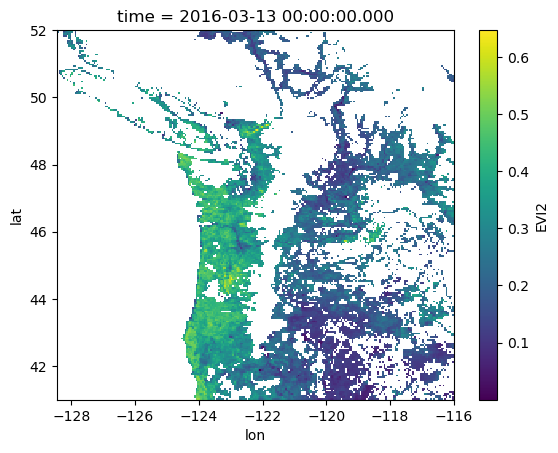

In [68]:
ds.EVI2.plot()